The dataset contains churn status of 10,000 customers. It also includes attributes that could impact churn such as:

* Credit score
* Geographical location (Germany, France, Spain)
* Gender (male, female)
* Age
* Tenure (years of being bank's customer)
* Account balance
* Estimated salary
* Number of products that a customer has purchased through the bank
* Credit card status (whether a customer has a credit card or not)
* Active member status (whether an active bank's customer or not)

The event that defines the customer's churn is the closing of the customer's bank account. The column exited in the dataset refers to customer's abandonment. There isn't much context available about these attributes so we have to proceed without having background information about the dataset. 

**Goal: Understand what factors influence customer churn (exited = 1), and build an ML model to predict churn probability.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, log_loss
from sklearn.inspection import permutation_importance

# 🔽 1. Data Loading

In [38]:
# Set seed for reproducibility
np.random.seed(42)
n = 5000

# Synthetic data generation
data = {
    "credit_score": np.random.normal(loc=650, scale=50, size=n).astype(int),  # typical range 300–850
    "geography": np.random.choice(["Germany", "France", "Spain"], size=n, p=[0.4, 0.3, 0.3]),
    "gender": np.random.choice(["Male", "Female"], size=n),
    "age": np.random.normal(loc=40, scale=10, size=n).clip(18, 90).astype(int),
    "tenure": np.random.randint(0, 11, size=n),  # 0 to 10 years
    "balance": np.random.choice(
        [0] * 1000 + list(np.random.uniform(1000, 250000, size=n - 1000)),  # 20% have 0 balance
        size=n
    ),
    "estimated_salary": np.random.uniform(20000, 150000, size=n),
    "num_of_products": np.random.choice([1, 2, 3, 4], size=n, p=[0.6, 0.3, 0.08, 0.02]),
    "has_credit_card": np.random.choice([1, 0], size=n, p=[0.7, 0.3]),
    "is_active_member": np.random.choice([1, 0], size=n, p=[0.6, 0.4])
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Generate churn probability based on weighted factors (simplified logic)
churn_prob = (
    (df['age'] > 50).astype(int) * 0.2 +
    (df['balance'] == 0).astype(int) * 0.3 +
    (df['is_active_member'] == 0).astype(int) * 0.25 +
    (df['num_of_products'] == 1).astype(int) * 0.1 +
    (df['geography'] == "Germany").astype(int) * 0.1 +
    np.random.uniform(0, 0.1, size=n)  # random noise
)

df['exited'] = (churn_prob > 0.5).astype(int)

In [39]:
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      5000 non-null   int64  
 1   geography         5000 non-null   object 
 2   gender            5000 non-null   object 
 3   age               5000 non-null   int64  
 4   tenure            5000 non-null   int64  
 5   balance           5000 non-null   float64
 6   estimated_salary  5000 non-null   float64
 7   num_of_products   5000 non-null   int64  
 8   has_credit_card   5000 non-null   int64  
 9   is_active_member  5000 non-null   int64  
 10  exited            5000 non-null   int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 429.8+ KB


,credit_score,geography,gender,age,tenure,balance,estimated_salary,num_of_products,has_credit_card,is_active_member,exited
0,674,Germany,Female,56,4,56468.703228,110769.548341,2,0,1,0
1,643,Germany,Female,37,7,0.000000,21295.084666,1,1,1,1
2,682,France,Male,40,6,100266.113925,126703.815924,1,1,0,0
3,726,Germany,Female,29,10,0.000000,134695.350589,1,1,0,1
4,638,Germany,Male,32,1,0.000000,147521.440395,1,1,0,1


In [3]:
print(df.describe())

       credit_score          age       tenure        balance  \
count   5000.000000  5000.000000  5000.000000    5000.000000   
mean     649.782000    39.725600     4.993000  100674.261017   
std       49.816186     9.910901     3.121682   80230.828510   
min      487.000000    18.000000     0.000000       0.000000   
25%      617.000000    33.000000     2.000000   18320.734688   
50%      650.000000    40.000000     5.000000   95893.862549   
75%      683.000000    46.000000     8.000000  169287.829669   
max      846.000000    84.000000    10.000000  249924.206729   

       estimated_salary  num_of_products  has_credit_card  is_active_member  \
count       5000.000000       5000.00000      5000.000000        5000.00000   
mean       84222.122346          1.52940         0.695200           0.59880   
std        37474.112415          0.74488         0.460369           0.49019   
min        20013.308428          1.00000         0.000000           0.00000   
25%        52250.212433     

# 🧼 2. Data Cleaning

In [40]:
df.isnull().sum()

0

In [41]:
df.duplicated().sum()

0

# 📊 3. Exploratory Data Analysis (EDA)

### Univariate Analysis:
- Histogram of age, balance, salary
- Bar charts for categorical variables (e.g., geography, gender)


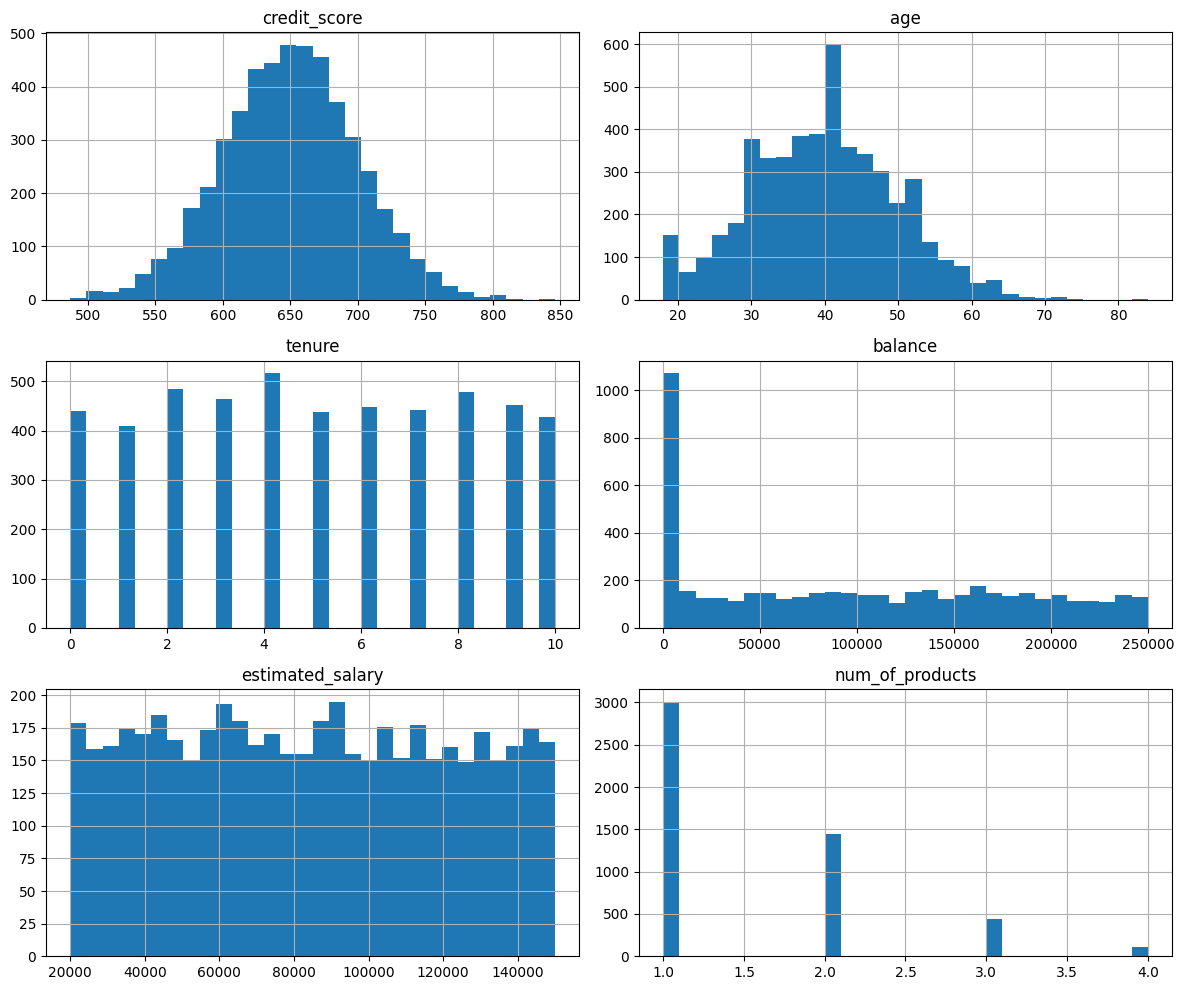

In [7]:
# Numeric Features
numeric_cols = ['credit_score', 'age', 'tenure', 'balance', 'estimated_salary', 'num_of_products']
df[numeric_cols].hist(bins=30, figsize=(12,10))
plt.tight_layout()

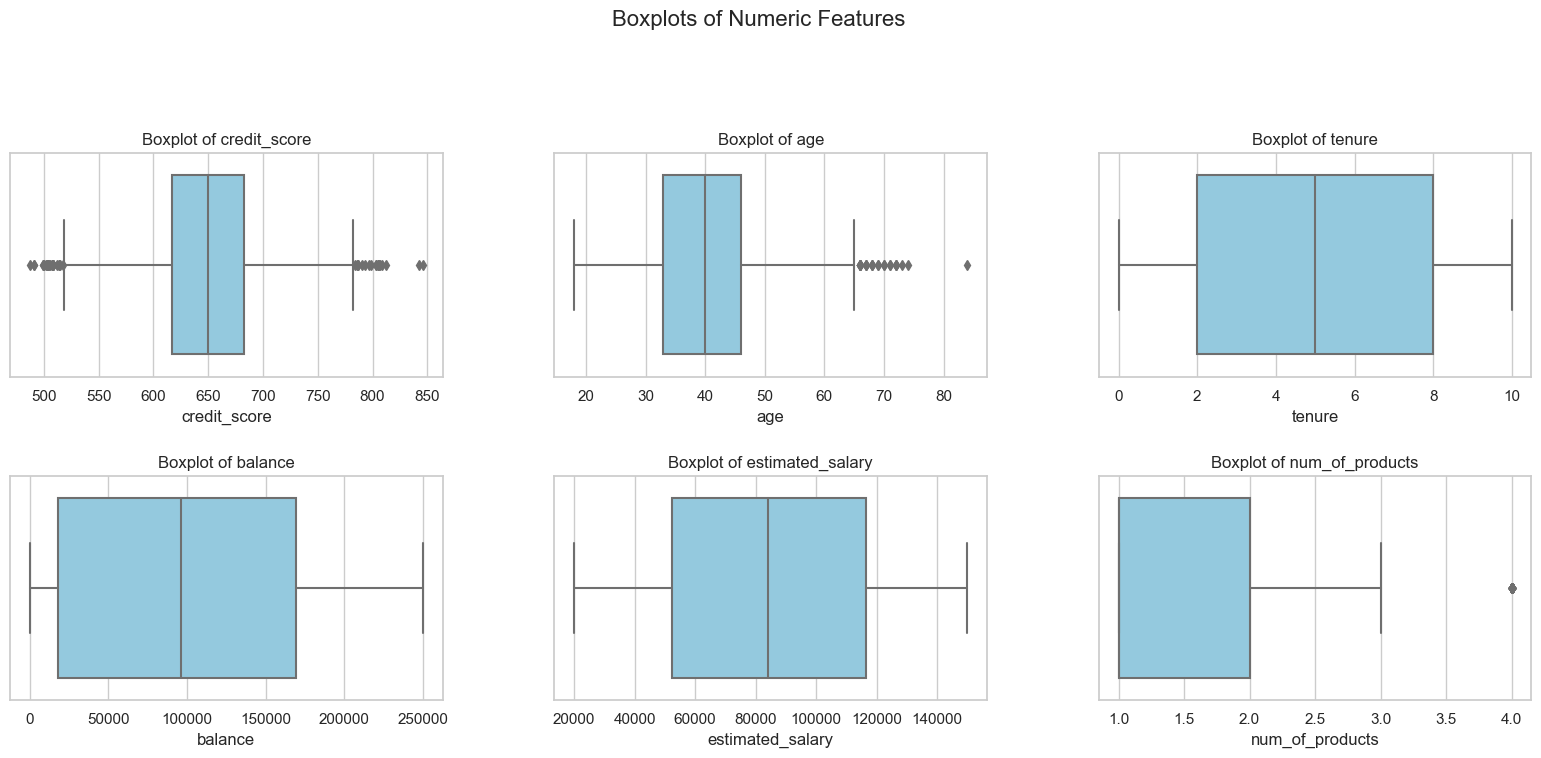

In [9]:
sns.set(style="whitegrid")

numeric_cols = ['credit_score', 'age', 'tenure', 'balance', 'estimated_salary', 'num_of_products']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(17, 8))
fig.suptitle('Boxplots of Numeric Features', fontsize=16)
fig.tight_layout(pad=4.0)

for i, col in enumerate(numeric_cols):
    row = i // 3
    col_idx = i % 3
    sns.boxplot(x=df[col], ax=axes[row][col_idx], color='skyblue')
    axes[row][col_idx].set_title(f'Boxplot of {col}', fontsize=12)
    axes[row][col_idx].set_xlabel(col)

plt.show()


### Class Balance:

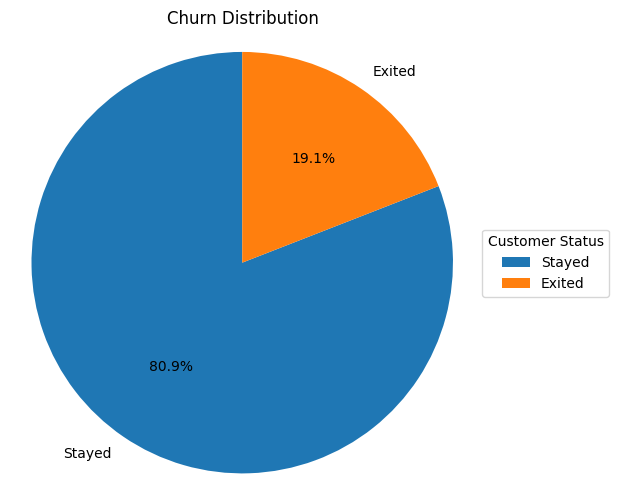

In [6]:
# Map 0 to "Stayed" and 1 to "Exited"
label_map = {0: 'Stayed', 1: 'Exited'}
counts = df['exited'].value_counts(normalize=True)

# Create custom labels
labels = [label_map[i] for i in counts.index]
sizes = counts.values

# Plot
plt.figure(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(
    sizes, labels=labels, autopct='%1.1f%%', startangle=90
)
plt.title('Churn Distribution')
plt.axis('equal')  # Make it a circle

# Add legend
plt.legend(wedges, labels, title='Customer Status', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


📈 4. Univariate Analysis (Independent Variables)

### Bivariate Analysis:
- Compare churn rate (exited) by:
- Geography
- Gender
- Active member
- Number of products

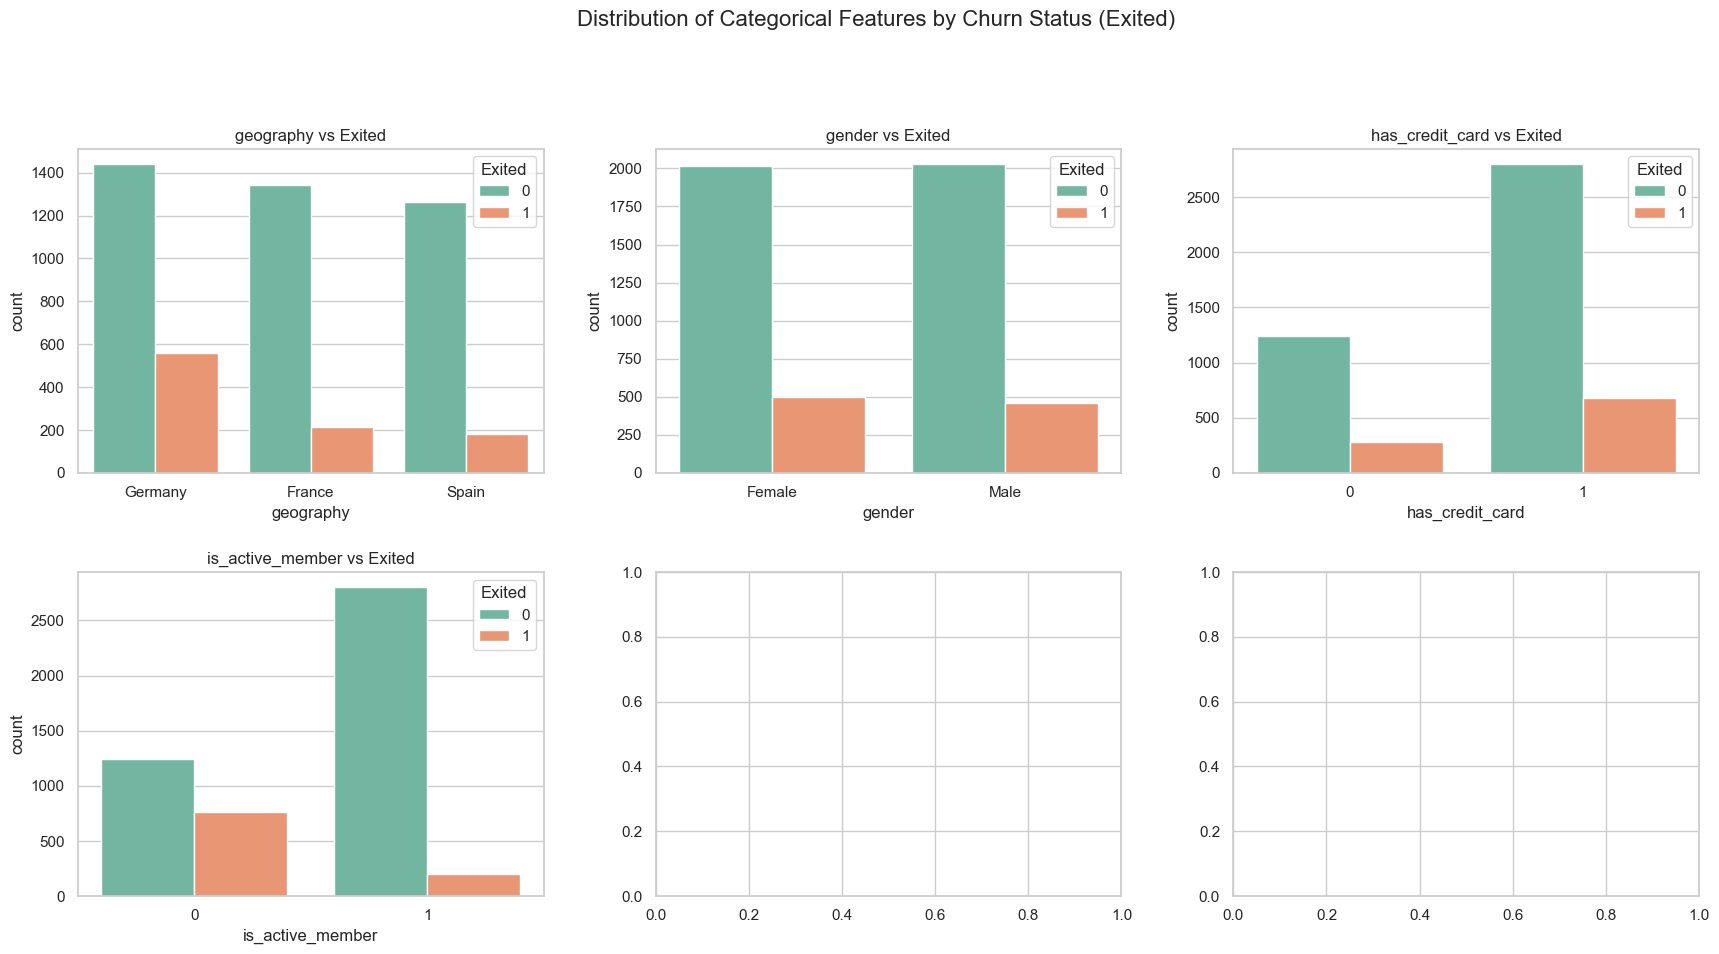

In [8]:
sns.set(style="whitegrid")

cat_cols = ['geography', 'gender', 'has_credit_card', 'is_active_member']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Distribution of Categorical Features by Churn Status (Exited)', fontsize=16)
fig.tight_layout(pad=4.0)

for i, col in enumerate(cat_cols):
    row = i // 3
    col_idx = i % 3
    sns.countplot(data=df, x=col, hue='exited', ax=axes[row][col_idx], palette='Set2')
    axes[row][col_idx].set_title(f'{col} vs Exited', fontsize=12)
    axes[row][col_idx].legend(title='Exited')

plt.show()


### Correlation Matrix:

- Visualize data.
- Check for multicollinearity.
- Use correlation matrices for numeric features.

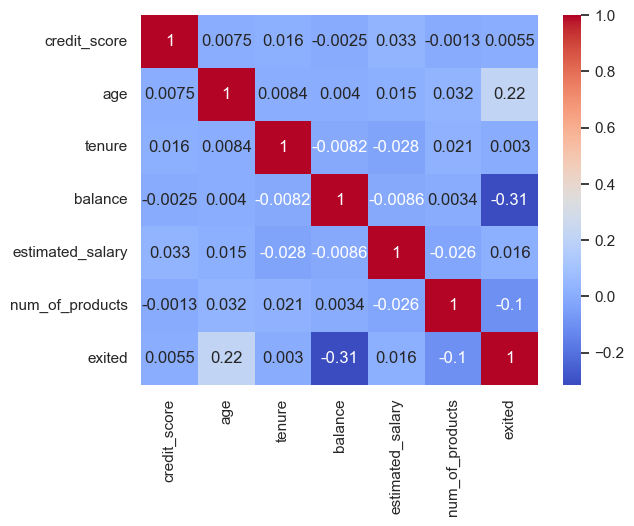

In [10]:
numeric_cols = ['credit_score', 'age', 'tenure', 'balance', 'estimated_salary', 'num_of_products']
cat_cols = ['geography', 'gender', 'has_credit_card', 'is_active_member']

# Correlation heatmap
sns.heatmap(df[numeric_cols + ['exited']].corr(), annot=True, cmap='coolwarm')
plt.show()

### 🧠 4. Feature Engineering (One Hot Encode) & Selection

- Mutual Information (independent vars and target var)
- Feature importance from tree-based models (e.g., Random Forest)
- Correlation analysis

In [11]:
from sklearn.feature_selection import mutual_info_classif

X = df[numeric_cols + cat_cols]
y = df['exited']
X_encoded = pd.get_dummies(X, drop_first=True)  # One-hot encode categoricals

mi_scores = mutual_info_classif(X_encoded, y, discrete_features='auto')
mi_df = pd.DataFrame({'Feature': X_encoded.columns, 'MI Score': mi_scores})
mi_df.sort_values(by='MI Score', ascending=False, inplace=True)
print(mi_df)

              Feature  MI Score
3             balance  0.111327
7    is_active_member  0.084103
1                 age  0.042297
8   geography_Germany  0.011679
9     geography_Spain  0.009177
10        gender_Male  0.003855
6     has_credit_card  0.002194
0        credit_score  0.000000
2              tenure  0.000000
4    estimated_salary  0.000000
5     num_of_products  0.000000


In [12]:
# based on MI score, select the most informative features 

# Step 1: Filter features with MI Score > 0.002
selected_features = mi_df[mi_df['MI Score'] > 0.002]['Feature'].tolist()

# Step 2: Keep only those columns in your feature set
X_selected = X_encoded[selected_features]

print("Selected features based on MI Score > 0.002:")
print(selected_features)

Selected features based on MI Score > 0.002:
['balance', 'is_active_member', 'age', 'geography_Germany', 'geography_Spain', 'gender_Male', 'has_credit_card']


Step 3: Model-Based Feature Importance (Optional)
Use a quick Random Forest to assess feature importance before final modeling.

In [13]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_selected, y)
importances = rf.feature_importances_

feat_imp = pd.DataFrame({'Feature': X_selected.columns, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)
print(feat_imp)


             Feature  Importance
0            balance    0.437177
2                age    0.250032
1   is_active_member    0.231816
3  geography_Germany    0.060950
4    geography_Spain    0.008716
5        gender_Male    0.005860
6    has_credit_card    0.005449


# 🛠️ 6. Modeling

Churn probability prediction ML model

 Step 1: Train-Test Split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

Step 2: Feature Scaling (Optional but recommended for Logistic Regression)

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

📈 Step 3: Train Models

Choose a Classifier That Supports Probabilities

Most classifiers in scikit-learn support .predict_proba(), like:

- LogisticRegression

- RandomForestClassifier

- GradientBoostingClassifier

- XGBClassifier (from xgboost)

1. Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_scaled, y_train)


LogisticRegression(max_iter=1000, random_state=42)

2. Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

3. XGBoost

In [18]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

📊 Step 4: Evaluate Models

- Accuracy
- Precision, Recall, F1-Score
- ROC AUC
- Confusion Matrix

In [19]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

models = {
    'Logistic Regression': (logreg, X_test_scaled),
    'Random Forest': (rf, X_test),
    'XGBoost': (xgb, X_test)
}

for name, (model, X_eval) in models.items():
    y_pred = model.predict(X_eval)
    y_proba = model.predict_proba(X_eval)[:, 1]

    print(f"\n{name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_proba))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))



Logistic Regression
Accuracy: 0.853
ROC AUC: 0.9134960749163533
Confusion Matrix:
 [[759  50]
 [ 97  94]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.94      0.91       809
           1       0.65      0.49      0.56       191

    accuracy                           0.85      1000
   macro avg       0.77      0.72      0.74      1000
weighted avg       0.84      0.85      0.84      1000


Random Forest
Accuracy: 0.936
ROC AUC: 0.9787598936053171
Confusion Matrix:
 [[780  29]
 [ 35 156]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       809
           1       0.84      0.82      0.83       191

    accuracy                           0.94      1000
   macro avg       0.90      0.89      0.90      1000
weighted avg       0.94      0.94      0.94      1000


XGBoost
Accuracy: 0.935
ROC AUC: 0.9829567884855585
Confusion Matrix:
 [[778  31]
 [ 34 1

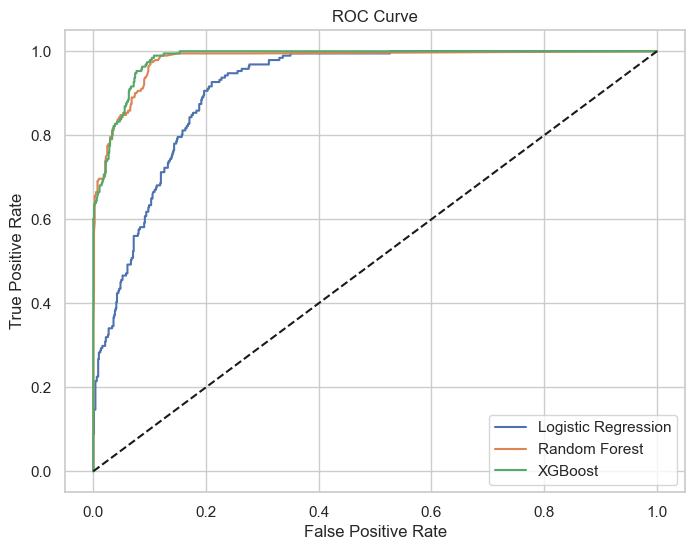

In [21]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

for name, (model, X_eval) in models.items():
    y_proba = model.predict_proba(X_eval)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


### Simulate 100 new customers and predict the probability of churn using the trained ML model.

In [29]:
# Step 1: Generate synthetic customer data
np.random.seed(42)
n = 100

new_data = pd.DataFrame({
    'credit_score': np.random.randint(350, 850, size=n),
    'age': np.random.randint(18, 90, size=n),
    'tenure': np.random.randint(0, 11, size=n),
    'balance': np.random.uniform(0, 250000, size=n),
    'estimated_salary': np.random.uniform(10000, 200000, size=n),
    'num_of_products': np.random.choice([1, 2, 3, 4], size=n, p=[0.5, 0.3, 0.15, 0.05]),
    'geography': np.random.choice(['France', 'Germany', 'Spain'], size=n),
    'gender': np.random.choice(['Male', 'Female'], size=n),
    'has_credit_card': np.random.choice([0, 1], size=n, p=[0.3, 0.7]),
    'is_active_member': np.random.choice([0, 1], size=n, p=[0.4, 0.6])
})

# Step 2: One-hot encode categorical features to match training preprocessing
new_data_encoded = pd.get_dummies(new_data, drop_first=True)

# Step 3: Ensure all expected features are present (add missing columns with 0s)
expected_features = ['balance', 'is_active_member', 'age',
                     'geography_Germany', 'geography_Spain',
                     'gender_Male', 'has_credit_card']

for col in expected_features:
    if col not in new_data_encoded.columns:
        new_data_encoded[col] = 0

# Step 4: Reorder columns to match training feature order
X_new = new_data_encoded[expected_features]

# Step 5: Predict churn probability
churn_probs = xgb.predict_proba(X_new)[:, 1]

# Step 6: Add predictions to dataframe
new_data['churn_probability'] = churn_probs

# Step 7: Sort and display top customers most likely to churn
top_churn_risks = new_data.sort_values(by='churn_probability', ascending=False).head(10)

In [35]:
# Step 8: Display result
print("Top 10 customers most likely to churn\n")
print(top_churn_risks[['balance', 'is_active_member', 'age', 'churn_probability']])


print("\nFirst 10 rows\n")
print(new_data[['balance', 'is_active_member', 'age', 'churn_probability']].head(10))

Top 10 customers most likely to churn

          balance  is_active_member  age  churn_probability
14  223011.638794                 0   62           0.998360
87  132838.657892                 0   61           0.998274
51  185192.154439                 0   80           0.996813
68   93895.738160                 0   74           0.996443
4   162408.224762                 0   89           0.996428
40   42373.186672                 0   82           0.994959
6   164403.223075                 0   57           0.994950
32  107046.037079                 0   51           0.993997
61  125379.073672                 0   88           0.992901
39   79230.501289                 0   52           0.984446

First 10 rows

         balance  is_active_member  age  churn_probability
0  178044.805337                 0   79           0.963495
1   59312.271874                 1   31           0.000026
2   81349.924540                 1   65           0.002329
3  186622.851280                 1   32          